In [1]:
import os
import glob
import pickle

import numpy as np
import skimage.io as io
import scipy.io as sio
from scipy.optimize import curve_fit
from matplotlib.path import Path
from skimage.draw import disk
import matplotlib.pyplot as plt
import seaborn as sns
from roifile import ImagejRoi

/Users/ykhao/opt/anaconda3/envs/flybrain/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# overlaying the mini propagation events on top of the image

In [ ]:
cmaps = sns.color_palette("Set2", n_colors=50)

# working_dir = '/Volumes/CLab/dendritic_scaling/screened_results/'
working_dir = '/Volumes/MyPassport/dendritic_scaling/screened_results_240209_newfilter/'
npy_list = glob.glob(working_dir + '/*.npy')
for npy_file in npy_list:
    # load the npy file
    with open(npy_file, 'rb') as f:
        binned_image = np.load(f, allow_pickle=True)
    binned_image_mean = np.mean(binned_image, axis=-1)

    file_id = os.path.basename(npy_file).split('_binned_img')[0]
    # load the mat file in the mini_info folder
    mat_list = glob.glob(os.path.join(working_dir, file_id+'_mini_info_list', '*.mat'))
    x_list = []
    y_list = []
    for mat_file in mat_list:
        # load the mat file
        mat = sio.loadmat(mat_file)
        x_list.append(mat['x'].flatten())
        y_list.append(mat['y'].flatten())

    # plot the binned image mean
    # on the image, scatter the x and y coordinates
    fig, ax = plt.subplots()
    ax.imshow(binned_image_mean.T, cmap='gray')
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        ax.scatter(x, y, s=5, c=cmaps[i])
    # save the figure
    fig.savefig(os.path.join(working_dir, file_id+'_binned_img_mean.png'))
    plt.close(fig)
    # save the mean image as tif
    io.imsave(os.path.join(working_dir, file_id+'_binned_img_mean.tif'), binned_image_mean.T.astype(np.uint16))

# Tracing events

In [2]:
class Dendrite(object):
    def __init__(self, vertices):
        self.vertices = vertices  # vertice should be (N, 2) array
        accumulated_distance = np.cumsum(np.linalg.norm(np.diff(vertices, axis=0), axis=1))
        self.accumulated_distance = np.insert(accumulated_distance, 0, 0)

    def distance_to_point(self, point):
        return np.min(np.linalg.norm(self.vertices - point, axis=1))
    
    def distance_to_point_set(self, point_set):
        return np.array([self.distance_to_point(point) for point in point_set]).sum()
    
    def distance_to_soma(self, point):
        point_to_path_dist = np.linalg.norm(self.vertices - point, axis=1)
        closest_point = np.argmin(point_to_path_dist)
        return self.accumulated_distance[closest_point] + point_to_path_dist[closest_point]

In [3]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs # nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


class DendriteTracer(object):
    def __init__(self, working_dir, file_id):
        self.working_dir = working_dir
        self.file_id = file_id
        self.npy_file = os.path.join(working_dir, file_id+'_binned_img.npy')
        self.mat_list = glob.glob(os.path.join(working_dir, file_id+'_mini_info_list', '*.mat'))
        self.mat_list.sort()
        self.dendrites = ImagejRoi.fromfile(os.path.join(working_dir, file_id+'_mini_info_list', "RoiSet.zip"))
        self.dendrite_list = self._construct_dendrite_list()
        self.F = []
        self.D = []
        self.SF = [] # soma signal
        self.Kds = [] # propagation coefficient K from dendrite to soma
        self.soma_snr = [] # soma signal to noise ratio
        self._load_data()
    
    def _construct_dendrite_list(self):
        dendrite_list = []
        for branch in self.dendrites:
            branch_path = Path(branch.coordinates())
            interp_xy = branch_path.interpolated(10).vertices
            dendrite = Dendrite(interp_xy)
            dendrite_list.append(dendrite)
        return dendrite_list
    
    def _load_data(self):
        with open(self.npy_file, 'rb') as f:
            self.binned_image = np.load(f, allow_pickle=True)
        x_list = []
        y_list = []
        peak_list = []
        peak_amplitude_list = []
        dff_list = []
        for mat_file in self.mat_list:
            # load the mat file
            mat = sio.loadmat(mat_file)
            dff = mat['dff_around_peak']
            x_list.append(mat['x'].flatten())
            y_list.append(mat['y'].flatten())
            peak_list.append(mat['peak'].flatten())
            peak_amplitudes = np.abs(np.min(mat['dff_around_peak'], axis=1) - np.mean(mat['dff_around_peak'][:, :18], axis=1))
            peak_amplitude_list.append(peak_amplitudes)
            dff_list.append(dff)
        self.x_list = x_list
        self.y_list = y_list
        self.peak_list = peak_list
        self.peak_amplitude_list = peak_amplitude_list
        self.dff_list = dff_list

    def _find_initiation_site(self, peak, peak_amplitude, noise_tolerance=0.5):
        # a simple way to find the initiation site is to find the pixel with the largest amplitude
        # return np.argmax(peak_amplitude)
        # a more sophisticated way is to find the pixel with the largest amplitude and earlier than weighted average peak time
        weighted_average_peak_time = np.sum(peak*peak_amplitude)/np.sum(peak_amplitude)  
        return np.argmax(peak_amplitude*(peak<=weighted_average_peak_time+noise_tolerance))
    
    def _get_distances_to_soma(self, x, y):
        distances = []
        for xp, yp in zip(x, y):
            which_dendrite = np.argmin([dendrite.distance_to_point(np.array([xp, yp])) for dendrite in self.dendrite_list])
            DOI = self.dendrite_list[which_dendrite]
            distances.append(DOI.distance_to_soma(np.array([xp, yp])))
        return distances
    
    def get_mini_initiation(self):
        n_propagation = len(self.x_list)
        for i in range(n_propagation):
            x = self.x_list[i]
            y = self.y_list[i]
            peak_amplitude = self.peak_amplitude_list[i]
            peak_time = self.peak_list[i]
            # for each propagation, find the closest dendrite
            # and calculate the distance to the soma
            which_pixel = self._find_initiation_site(peak_time, peak_amplitude)
            xp = x[which_pixel]
            yp = y[which_pixel]
            which_dendrite = np.argmin([dendrite.distance_to_point(np.array([xp, yp])) for dendrite in self.dendrite_list])
            DOI = self.dendrite_list[which_dendrite]
            distance_to_soma = DOI.distance_to_soma(np.array([xp, yp]))
            self.F.append(peak_amplitude[which_pixel])
            self.D.append(distance_to_soma)

    def get_soma_mask(self, soma_radius=4):
        binned_image_mean = np.mean(self.binned_image, axis=-1)
        xy = self.dendrites[0].coordinates()
        # get the signal masked by the disk
        soma_disk = disk((xy[0, 0], xy[0, 1]), soma_radius)
        soma_disk = np.array(soma_disk)
        # remove the out of bound pixels
        soma_disk = soma_disk[:, (soma_disk[1] >= 0) & (soma_disk[1] < binned_image_mean.shape[1])]
        soma_disk = soma_disk[:, (soma_disk[0] >= 0) & (soma_disk[0] < binned_image_mean.shape[0])]
        self.soma_disk = soma_disk

    def get_mini_soma(self, fs=200, cutoff=0.5, order=5):
        self.get_soma_mask()
        binned_image_mean = np.mean(self.binned_image, axis=-1)
        # use soma_disk to mask the binned_image_mean
        soma_signal = self.binned_image[(self.soma_disk[0], self.soma_disk[1])]
        mean_soma_signal = soma_signal.mean(axis=0)[int(fs):]  # remove the first 1 second
        # remove the background
        background = np.percentile(binned_image_mean, 10)
        mean_soma_signal = mean_soma_signal - background
        # calculate the baesline and then dff
        neuron_traces_filt  = butter_lowpass_filter(mean_soma_signal, cutoff, fs, order)
        dff = (mean_soma_signal - neuron_traces_filt)/neuron_traces_filt
        self.soma_signal = dff

        n_propagation = len(self.peak_list)
        for i in range(n_propagation):
            peak_amplitude = self.peak_amplitude_list[i]
            peak_time = self.peak_list[i]
            peak_time = int(np.round(np.sum(peak_time*peak_amplitude)/np.sum(peak_amplitude) ))
            soma_peak_amplitude = np.abs( np.min(dff[peak_time-2:peak_time+5]) - np.mean(dff[peak_time-20:peak_time-5]) )
            self.SF.append(soma_peak_amplitude)
            soma_peak_snr = soma_peak_amplitude/np.std(dff[peak_time-25:peak_time-5])
            self.soma_snr.append(soma_peak_snr)
    
    # def get_mini_soma(self):
    #     n_propagation = len(self.x_list)
    #     for i in range(n_propagation):
    #         x = self.x_list[i]
    #         y = self.y_list[i]
    #         peak_amplitude = self.peak_amplitude_list[i]
    #         distances = self._get_distances_to_soma(x, y)
    #         soma_radius = 6  # 4 pixels, 20 um
    #         if np.min(distances) < soma_radius:
    #             # soma signal is the mean signal of pixels within 5 pixels of soma
    #             self.SF.append(np.mean(peak_amplitude[np.array(distances)<soma_radius]))
    #         else:
    #             self.SF.append(0)
    
    def save_QC_figure(self):
        if len(self.SF) == 0:
            self.get_mini_soma()
        n_propagation = len(self.x_list)
        for i in range(n_propagation):
            x = self.x_list[i]
            y = self.y_list[i]
            peak_amplitude = self.peak_amplitude_list[i]
            peak_time = self.peak_list[i]
            # for each propagation, find the closest dendrite
            # and calculate the distance to the soma
            which_pixel = self._find_initiation_site(peak_time, peak_amplitude)
            xp = x[which_pixel]
            yp = y[which_pixel]
            which_dendrite = np.argmin([dendrite.distance_to_point(np.array([xp, yp])) for dendrite in self.dendrite_list])
            DOI = self.dendrite_list[which_dendrite]
            distance_to_soma = DOI.distance_to_soma(np.array([xp, yp]))
            distances = self._get_distances_to_soma(x, y)
            # draw three subplots, 
            # first save the QC figure with mean image, DOI and the pixel with the largest amplitude 
            # second one is showing the dff trace
            # third one is showing the peak amplitude vs distance to soma
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            axes[0].imshow(np.mean(self.binned_image, axis=-1).T, cmap='gray')
            axes[0].scatter(self.soma_disk[0], self.soma_disk[1], s=5, c='b')
            axes[0].scatter(x, y, s=5, c='g')
            axes[0].scatter(xp, yp, s=30, c='r')
            axes[0].plot(DOI.vertices[:, 0], DOI.vertices[:, 1], c='b')
            axes[0].set_title('DOI distance to soma: '+str(distance_to_soma))
            distal_trace = self.dff_list[i][which_pixel]
            distal_trace = distal_trace - np.mean(distal_trace[:15])
            axes[1].plot(distal_trace)
            axes[1].set_title('peak amplitude: '+str(peak_amplitude[which_pixel]))

            event_time_center = int(np.round(np.sum(peak_time*peak_amplitude)/np.sum(peak_amplitude) ))
            view_window = [event_time_center-20, event_time_center+20]
            if view_window[0] < 0:
                view_window = [0, 40]
            if view_window[1] > len(self.soma_signal):
                view_window = [len(self.soma_signal)-40, len(self.soma_signal)]
            somatic_trace = self.soma_signal[view_window[0]:view_window[1]]
            somatic_trace = somatic_trace - np.mean(somatic_trace[:15])
            axes[2].plot(somatic_trace)
            soma_dendrite_correration = np.corrcoef(distal_trace, somatic_trace)[0, 1]
            self.Kds.append(soma_dendrite_correration)
            # print the correlation coefficient to 4 decimal places
            axes[2].set_title('soma-dendrite correlation: '+str(np.round(soma_dendrite_correration, 4)))

            
            axes[3].plot(distances, peak_amplitude, 'o')
            axes[3].scatter(0.2, self.SF[i], s=30, c='r')
            axes[3].scatter(distance_to_soma, peak_amplitude[which_pixel], s=80, facecolors='none', edgecolors='b')
            axes[3].set_xlim([0, np.max(distances)+5])
            axes[3].set_ylim([0, np.max(peak_amplitude)+0.05])
            axes[3].set_xlabel('distance to soma')
            axes[3].set_ylabel('peak amplitude')
            axes[3].plot(distances, peak_amplitude, 'o')

            save_dir = os.path.join(self.working_dir, self.file_id+'_distance_QC')
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            event_file = self.mat_list[i]
            event_id = os.path.basename(event_file).split('.')[0]
            fig.savefig(os.path.join(save_dir, 'QC_'+event_id+'.png'))
            plt.close(fig)

    def save_traced_data(self):
        '''
        save the traced data into a list of dictionaries, each dictionary corresponds to one propagation event
        dictionary keys:
        initiation_site: (x, y) coordinates of the initiation site
        soma_site: (x, y) coordinates of the soma site
        distances: list of distances to the soma
        peak_amplitudes: list of peak amplitudes
        soma_peak_amplitude: soma peak amplitude
        initiation_peak_amplitude: initiation peak amplitude
        initiation_distance_to_soma: initiation distance to soma
        soma_snr: soma signal to noise ratio
        initiation_waveform: initiation waveform
        soma_waveform: soma waveform
        neuron_img: mean image of the neuron
        soma_mask: mask of the soma
        dendritic_path: list of the (x,y) coordinates of the dendritic path
        all_pixels_of_propagation: (x, y) coordinates of all pixels of the propagation
        '''
        if len(self.SF) == 0:
            self.get_mini_soma()
        if len(self.F) == 0:
            self.get_mini_initiation()
        n_propagation = len(self.x_list)
        propagation_events = []
        for i in range(n_propagation):
            pe = {}
            x = self.x_list[i]
            y = self.y_list[i]
            peak_amplitude = self.peak_amplitude_list[i]
            peak_time = self.peak_list[i]
            # for each propagation, find the closest dendrite
            # and calculate the distance to the soma
            which_pixel = self._find_initiation_site(peak_time, peak_amplitude)
            xp = x[which_pixel]
            yp = y[which_pixel]
            which_dendrite = np.argmin([dendrite.distance_to_point(np.array([xp, yp])) for dendrite in self.dendrite_list])
            DOI = self.dendrite_list[which_dendrite]
            distance_to_soma = DOI.distance_to_soma(np.array([xp, yp]))
            distances = np.array(self._get_distances_to_soma(x, y))
            distal_trace = self.dff_list[i][which_pixel]
            distal_trace = distal_trace - np.mean(distal_trace[:15])

            event_time_center = int(np.round(np.sum(peak_time*peak_amplitude)/np.sum(peak_amplitude) ))
            view_window = [event_time_center-20, event_time_center+20]
            if view_window[0] < 0:
                view_window = [0, 40]
            if view_window[1] > len(self.soma_signal):
                view_window = [len(self.soma_signal)-40, len(self.soma_signal)]
            somatic_trace = self.soma_signal[view_window[0]:view_window[1]]
            somatic_trace = somatic_trace - np.mean(somatic_trace[:15])

            pe['neuron_id'] = self.file_id  
            pe['initiation_site'] = (xp, yp)
            pe['soma_site'] = self.dendrites[which_dendrite].coordinates()[0]
            pe['distances'] = distances
            pe['peak_amplitudes'] = peak_amplitude
            pe['soma_peak_amplitude'] = self.SF[i]
            pe['initiation_peak_amplitude'] = self.F[i]
            pe['initiation_distance_to_soma'] = distance_to_soma
            pe['soma_snr'] = self.soma_snr[i]
            pe['initiation_waveform'] = distal_trace
            pe['soma_waveform'] = somatic_trace
            pe['neuron_img'] = np.mean(self.binned_image, axis=-1).T
            pe['soma_mask'] = self.soma_disk
            pe['dendritic_path'] = DOI.vertices
            pe['all_pixels_of_propagation'] = (x, y)
            
            propagation_events.append(pe)

        with open(os.path.join(self.working_dir, self.file_id + '_propagation_events.pkl'), 'wb') as f:
            pickle.dump(propagation_events, f)


In [5]:
# QC the dendrite tracer
# working_dir = '/Volumes/CLab/dendritic_scaling/screened_results_strict/'
working_dir = '/Volumes/MyPassport/dendritic_scaling/screened_results_240216_newfilter/'
npy_list = glob.glob(working_dir + '/*.npy')
for npy in npy_list:
    file_id = os.path.basename(npy).split('_binned_img')[0]
    #print(file_id)
    tracer = DendriteTracer(working_dir, file_id)
    tracer.save_QC_figure()

In [ ]:
# # putting the mat files back to the parent directory
# working_dir = '/Volumes/MyPassport/dendritic_scaling/screened_results_240215_newfilter_2/'
# npy_list = glob.glob(working_dir + '/*.npy')
# for npy in npy_list:
#     file_id = os.path.basename(npy).split('_binned_img')[0]
#     archive_dir = os.path.join(working_dir, file_id+'_mini_info_list', 'QC_failed')
#     # move all the mat file in the archive_dir to the parent directory
#     mat_list = glob.glob(archive_dir+'/*.mat')
#     for mat_file in mat_list:
#         os.rename(mat_file, os.path.join(working_dir, file_id+'_mini_info_list', os.path.basename(mat_file)))

# failed_mat_list = []
# for npy in npy_list:
#     file_id = os.path.basename(npy).split('_binned_img')[0]
#     archive_dir = os.path.join(working_dir, file_id+'_mini_info_list', 'QC_failed')
#     # move all the mat file in the archive_dir to the parent directory
#     mat_list = glob.glob(archive_dir+'/*.mat')
#     failed_mat_list += mat_list
# print(len(failed_mat_list))

In [ ]:
# first have to run the event_selector_QC.py 
# remove the events that fail the QC
working_dir = '/Volumes/MyPassport/dendritic_scaling/screened_results_240215_newfilter_2/'
npy_list = glob.glob(working_dir + '/*.npy')
for npy in npy_list:
    file_id = os.path.basename(npy).split('_binned_img')[0]
    mat_list = glob.glob(os.path.join(working_dir, file_id+'_mini_info_list', '*.mat'))
    QC_dir = os.path.join(working_dir, file_id+'_distance_QC')
    QC_files = glob.glob(QC_dir+'/*.png')
    # get the passed QC index
    passed_QC_id = []
    for QC_file in QC_files:
        passed_QC_id.append(QC_file.split('QC_')[1].split('.png')[0])
    print(passed_QC_id)
    # archive the mat files that didn't pass the QC
    archive_dir = os.path.join(working_dir, file_id+'_mini_info_list', 'QC_failed')
    if not os.path.exists(archive_dir):
        os.makedirs(archive_dir)
    for mat_file in mat_list:
        mat_id = os.path.basename(mat_file).split('.')[0]
        if mat_id not in passed_QC_id:
            os.rename(mat_file, os.path.join(archive_dir, os.path.basename(mat_file)))

In [4]:
#working_dir = '/Volumes/CLab/dendritic_scaling/screened_results_strict/'
# working_dir = '/Volumes/MyPassport/dendritic_scaling/screened_results_240215_newfilter_2/'
# npy_list = glob.glob(working_dir + '/*.npy')
working_dir = ['/Volumes/MyPassport/dendritic_scaling/screened_results_240209_newfilter_2/',
               '/Volumes/MyPassport/dendritic_scaling/screened_results_240215_newfilter_2/',
               '/Volumes/MyPassport/dendritic_scaling/screened_results_240216_newfilter_2/']  # this dataset newfilter_2 has a looser selection criteria for soma waveform
npy_list = [glob.glob(wd + '/*.npy') for wd in working_dir]
npy_list = [item for sublist in npy_list for item in sublist]

Distances = []
Amplitudes = []
SomaSignal = []
Kds = []
SomaSNR = []
for npy in npy_list:
    file_id = os.path.basename(npy).split('_binned_img')[0]
    #print(file_id)
    tracer = DendriteTracer(os.path.dirname(npy), file_id)
    tracer.get_mini_initiation()
    tracer.get_mini_soma()
    #tracer.save_QC_figure()
    Distances.append(tracer.D)
    Amplitudes.append(tracer.F)
    SomaSignal.append(tracer.SF)
    SomaSNR.append(tracer.soma_snr)
    #Kds.append(tracer.Kds)

In [6]:
pixel_size = 5.2  # um

(0.0, 0.3)

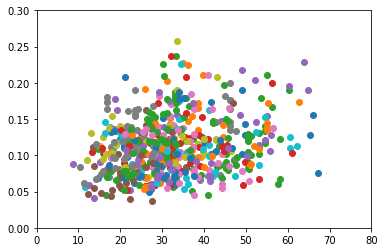

In [76]:
for i, (d, f) in enumerate(zip(Distances, Amplitudes)):
    # if i in [12, 6]:
    #     continue
    plt.scatter(np.array(d), np.array(f))
plt.xlim([0, 80])
plt.ylim([0, 0.3])

(0.0, 0.03)

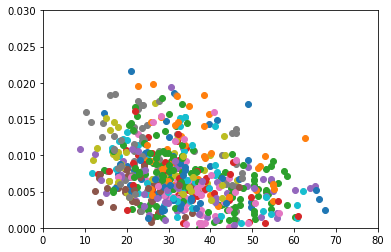

In [77]:
for i, (d, f) in enumerate(zip(Distances, SomaSignal)):
    plt.scatter(np.array(d), np.array(f))
plt.xlim([0, 80])
plt.ylim([0.0, 0.03])

(0.0, 80.0)

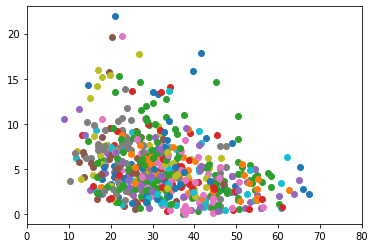

In [78]:
for i, (d, f) in enumerate(zip(Distances, SomaSNR)):
    plt.scatter(np.array(d), np.array(f))
plt.xlim([0, 80])

In [18]:
# now write the data to a csv file
import csv
event_count = []
cnt = 0
with open('mini_initiation_filtered6.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Distance', 'Amplitude', 'SomaSignal', 'SomaSNR'])
    for i, (d, f, s, snr) in enumerate(zip(Distances, Amplitudes, SomaSignal, SomaSNR)):
        event_count.append(len(d))
        if len(d) > 5:
            cnt += 1
            for j in range(len(d)):
                writer.writerow([d[j]*pixel_size, f[j], s[j], snr[j]])
print(cnt)

43


Text(0, 0.5, 'peak amplitude -dF/F')

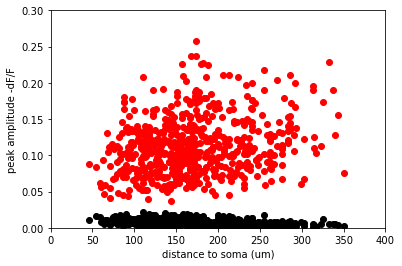

In [80]:
for i, (d, f) in enumerate(zip(Distances, Amplitudes)):
    # if i in [12, 6]:
    #     continue
    plt.scatter(np.array(d)*pixel_size, np.array(f), c='r')
for i, (d, f) in enumerate(zip(Distances, SomaSignal)):
    plt.scatter(np.array(d)*pixel_size, np.array(f), c='k')
plt.xlim([0, 400])
plt.ylim([0.0, 0.3])
plt.xlabel('distance to soma (um)')
plt.ylabel('peak amplitude -dF/F')

Text(0, 0.5, 'peak amplitude -dF/F')

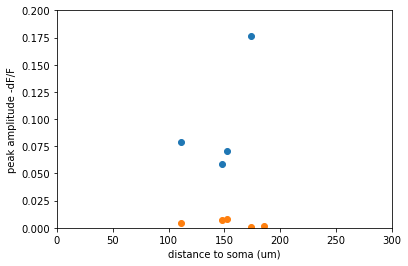

In [11]:
index = 0 #6, 12, 15
d = Distances[index]
f = Amplitudes[index]
sf = SomaSignal[index]
plt.scatter(np.array(d)*pixel_size, np.array(f))
plt.scatter(np.array(d)*pixel_size, np.array(sf))
plt.xlim([0, 300])
plt.ylim([0.00, 0.2])
plt.xlabel('distance to soma (um)')
plt.ylabel('peak amplitude -dF/F')

In [49]:
working_dir = '/Volumes/MyPassport/dendritic_scaling/screened_results_240209_newfilter/'
npy_list = glob.glob(working_dir + '/*.npy')
for npy in npy_list:
    file_id = os.path.basename(npy).split('_binned_img')[0]
    #print(file_id)
    tracer = DendriteTracer(working_dir, file_id)
    tracer.get_mini_initiation()
    tracer.get_mini_soma()
    d = np.array(tracer.D)
    f = np.array(tracer.F)
    sf = np.array(tracer.SF)
    plt.scatter(d*pixel_size, f)
    plt.scatter(d*pixel_size, sf)
    plt.xlim([0, 400])
    plt.ylim([0.0, 0.25])
    plt.xlabel('distance to soma (um)')
    plt.ylabel('peak amplitude -dF/F')
    # save the figure in QC folder
    # save_dir = os.path.join(working_dir, file_id+'_distance_QC')
    # if not os.path.exists(save_dir):
    #     print('no such directory')
    plt.savefig(os.path.join(working_dir, file_id+'initiation_vs_soma.png'))
    plt.close()


In [4]:
working_dir = ['/Volumes/MyPassport/dendritic_scaling/screened_results_240209_newfilter/',
               '/Volumes/MyPassport/dendritic_scaling/screened_results_240215_newfilter/',
               '/Volumes/MyPassport/dendritic_scaling/screened_results_240216_newfilter/']  # this dataset newfilter has a more strict selection criteria for soma waveform for propagation length study
npy_list = [glob.glob(wd + '/*.npy') for wd in working_dir]
npy_list = [item for sublist in npy_list for item in sublist]

for npy in npy_list:
    file_id = os.path.basename(npy).split('_binned_img')[0]
    #print(file_id)
    tracer = DendriteTracer(os.path.dirname(npy), file_id)
    tracer.save_traced_data()

In [4]:
working_dir = ['/Volumes/MyPassport/dendritic_scaling/screened_results_240209_newfilter_2/',
               '/Volumes/MyPassport/dendritic_scaling/screened_results_240215_newfilter_2/',
               '/Volumes/MyPassport/dendritic_scaling/screened_results_240216_newfilter_2/']  # this dataset newfilter_2 has a looser selection criteria for soma waveform
npy_list = [glob.glob(wd + '/*.npy') for wd in working_dir]
npy_list = [item for sublist in npy_list for item in sublist]

for npy in npy_list:
    file_id = os.path.basename(npy).split('_binned_img')[0]
    #print(file_id)
    tracer = DendriteTracer(os.path.dirname(npy), file_id)
    tracer.save_traced_data()

# dev of somatic events

In [4]:
working_dir = '/Volumes/MyPassport/dendritic_scaling/screened_results_240209/'
npy_list = glob.glob(working_dir + '/*.npy')
npy_file = npy_list[0]

In [5]:
# load the npy file
with open(npy_file, 'rb') as f:
    binned_image = np.load(f, allow_pickle=True)

In [6]:
binned_image_mean = np.mean(binned_image, axis=-1)
file_id = os.path.basename(npy_file).split('_binned_img')[0]
roi_path = os.path.join(working_dir, file_id+'_mini_info_list', "RoiSet.zip")
dendrites = ImagejRoi.fromfile(roi_path)
xy = dendrites[0].coordinates()

# draw a circle with radius 6 pixels around the soma
soma_radius = 4
theta = np.linspace(0, 2*np.pi, 100)
x = xy[0, 0] + soma_radius * np.cos(theta)
y = xy[0, 1] + soma_radius * np.sin(theta)
plt.plot(x, y, c='r')
# get the signal masked by the disk
soma_disk = disk((xy[0, 0], xy[0, 1]), soma_radius)
soma_disk = np.array(soma_disk)
# remove the out of bound pixels
soma_disk = soma_disk[:, (soma_disk[1] >= 0) & (soma_disk[1] < binned_image_mean.shape[0])]
# use soma_disk to mask the binned_image_mean
soma_signal = binned_image[(soma_disk[0], soma_disk[1])]


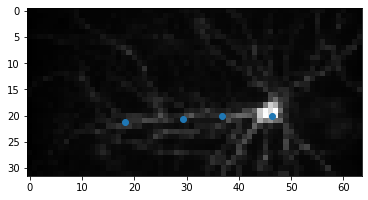

In [12]:
plt.imshow(binned_image_mean.T, cmap='gray')
plt.scatter(xy[:, 0], xy[:, 1])

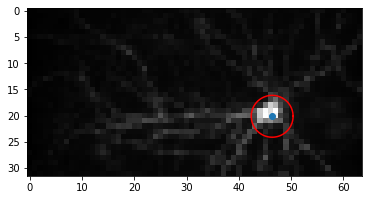

In [51]:
plt.imshow(binned_image_mean.T, cmap='gray')
plt.scatter(xy[0, 0], xy[0, 1])
# draw a circle with radius 6 pixels around the soma
soma_radius = 4
theta = np.linspace(0, 2*np.pi, 100)
x = xy[0, 0] + soma_radius * np.cos(theta)
y = xy[0, 1] + soma_radius * np.sin(theta)
plt.plot(x, y, c='r')
# get the signal masked by the disk
from skimage.draw import disk
soma_disk = disk((xy[0, 0], xy[0, 1]), soma_radius)
soma_disk = np.array(soma_disk)
# remove the out of bound pixels
soma_disk = soma_disk[:, (soma_disk[1] >= 0) & (soma_disk[1] < binned_image_mean.shape[0])]
# use soma_disk to mask the binned_image_mean
soma_signal = binned_image[(soma_disk[0], soma_disk[1])]


In [60]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs # nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [78]:
fs=200 
cutoff=0.5
order=5
mean_soma_signal = soma_signal.mean(axis=0)[200:]
background = np.percentile(binned_image.mean(2), 10)
mean_soma_signal = mean_soma_signal - background

neuron_traces_filt  = butter_lowpass_filter(mean_soma_signal, cutoff, fs, order)
dff = (mean_soma_signal - neuron_traces_filt)/neuron_traces_filt
time_vector = np.arange(mean_soma_signal.shape[0])/fs

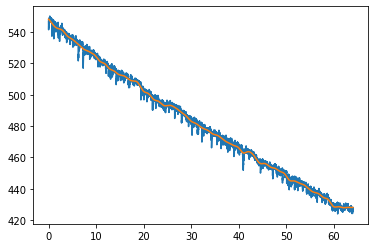

In [79]:
plt.plot(time_vector, mean_soma_signal)
plt.plot(time_vector, neuron_traces_filt)

(20.0, 30.0)

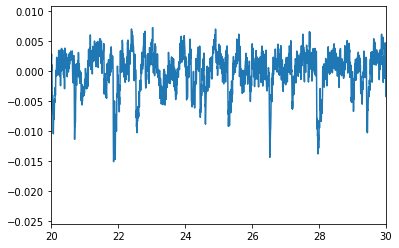

In [80]:
plt.plot(time_vector, dff)
plt.xlim([20, 30])

# dev

In [4]:
working_dir = '/Volumes/CLab/dendritic_scaling/dendritic_tracing/'
npy_list = glob.glob(working_dir + '/*.npy')
npy_file = npy_list[0]

In [5]:
# load the npy file
with open(npy_file, 'rb') as f:
    binned_image = np.load(f, allow_pickle=True)

In [6]:
binned_image_mean = np.mean(binned_image, axis=-1)

In [7]:
file_id = os.path.basename(npy_file).split('_binned_img')[0]
# load the mat file in the mini_info folder
mat_list = glob.glob(os.path.join(working_dir, file_id+'_mini_info_list', '*.mat'))

In [108]:
x_list = []
y_list = []
peak_amplitude_list = []
dff_list = []
for mat_file in mat_list:
    # load the mat file
    mat = sio.loadmat(mat_file)
    x_list.append(mat['x'].flatten())
    y_list.append(mat['y'].flatten())
    peak_amplitude_list.append(np.min(mat['dff_around_peak'], axis=1))
    dff_list.append(mat['dff_around_peak'])

In [9]:
# plot the binned image mean
# on the image, scatter the x and y coordinates
cmaps = sns.color_palette("Set2", n_colors=20)
fig, ax = plt.subplots()
ax.imshow(binned_image_mean.T, cmap='gray')
for i, (x, y) in enumerate(zip(x_list, y_list)):
    ax.scatter(x, y, s=5, c=cmaps[i])

# save the figure
fig.savefig(os.path.join(working_dir, file_id+'_binned_img_mean.png'))
plt.close(fig)
# save the mean image as tif
io.imsave(os.path.join(working_dir, file_id+'_binned_img_mean.tif'), binned_image_mean.T.astype(np.uint16))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

In [46]:
roi_path = os.path.join(working_dir, file_id+'_mini_info_list', "RoiSet.zip")
dendrites = ImagejRoi.fromfile(roi_path)

In [49]:
dendrites[0]

<ImagejRoi '0021-0020'>

In [22]:
xy = dendrites[0].coordinates()

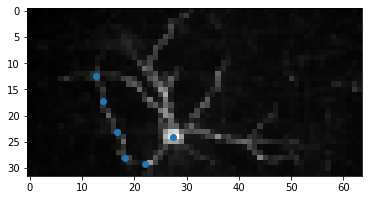

In [25]:
plt.imshow(binned_image_mean.T, cmap='gray')
plt.scatter(xy[:, 0], xy[:, 1])

In [27]:
branch = Path(xy)

In [34]:
interp_xy = branch.interpolated(10).vertices

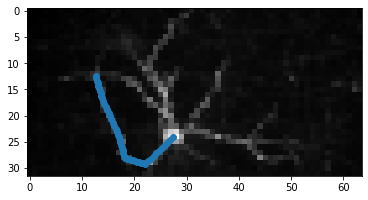

In [35]:
plt.imshow(binned_image_mean.T, cmap='gray')
plt.scatter(interp_xy[:, 0], interp_xy[:, 1])

In [41]:
accumulated_distance = np.cumsum(np.linalg.norm(np.diff(interp_xy, axis=0), axis=1))

In [2]:
class Dendrite(object):
    def __init__(self, vertices):
        self.vertices = vertices  # vertice should be (N, 2) array
        accumulated_distance = np.cumsum(np.linalg.norm(np.diff(vertices, axis=0), axis=1))
        self.accumulated_distance = np.insert(accumulated_distance, 0, 0)

    def distance_to_point(self, point):
        return np.min(np.linalg.norm(self.vertices - point, axis=1))
    
    def distance_to_point_set(self, point_set):
        return np.array([self.distance_to_point(point) for point in point_set]).sum()
    
    def distance_to_soma(self, point):
        point_to_path_dist = np.linalg.norm(self.vertices - point, axis=1)
        closest_point = np.argmin(point_to_path_dist)
        return self.accumulated_distance[closest_point] + point_to_path_dist[closest_point]

In [50]:
# construct all pathes in ROI to dendrite instances
dendrite_list = []
for branch in dendrites:
    branch_path = Path(branch.coordinates())
    interp_xy = branch_path.interpolated(10).vertices
    dendrite = Dendrite(interp_xy)
    dendrite_list.append(dendrite)

In [110]:
n_propagation = len(x_list)
F = []
D = []
for i in range(n_propagation):
    x = x_list[i]
    y = y_list[i]
    peak_amplitude = -peak_amplitude_list[i]
    # for each propagation, find the closest dendrite
    # and calculate the distance to the soma
    which_pixel = np.argmax(peak_amplitude)
    xp = x[which_pixel]
    yp = y[which_pixel]
    which_dendrite = np.argmin([dendrite.distance_to_point(np.array([xp, yp])) for dendrite in dendrite_list])
    DOI = dendrite_list[which_dendrite]
    distance_to_soma = DOI.distance_to_soma(np.array([xp, yp]))
    F.append(peak_amplitude.max())
    D.append(distance_to_soma)
    # draw two subplots, 
    # first save the QC figure with mean image, DOI and the pixel with the largest amplitude 
    # second one is showing the dff trace
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(binned_image_mean.T, cmap='gray')
    axes[0].scatter(x, y, s=5, c=cmaps[i])
    axes[0].scatter(xp, yp, s=30, c='r')
    axes[0].plot(DOI.vertices[:, 0], DOI.vertices[:, 1], c='b')
    axes[0].set_title('DOI distance to soma: '+str(distance_to_soma))
    axes[1].plot(dff_list[i][which_pixel])
    axes[1].set_title('peak amplitude: '+str(peak_amplitude.max()))
    fig.suptitle('QC_'+str(i))

    save_dir = os.path.join(working_dir, file_id+'_distance_QC')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    fig.savefig(os.path.join(save_dir, 'QC_'+str(i)+'.png'))
    plt.close(fig)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R